### Import libraries:

In [12]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import plot_confusion_matrix

### Load data:

In [2]:
data = pd.read_csv('../../data/clean/data_cleaned.csv')

data.head()

,gender,ethnicity,parental_education,lunch,test_preparation_course,pass/fail_math,math_score,pass/fail_reading,reading_score,pass/fail_writing,writing_score,failed_courses,midterm_results,average_grade
0,M,A,high school,standard,yes,passed,67,passed,67,passed,63,good standing,good standing,65.67
1,F,D,no high school,reduced,no,failed,40,failed,59,failed,55,math/reading,summer school,51.33
2,M,E,high school,reduced,no,failed,59,passed,60,failed,50,math/writing,summer school,56.33
3,M,B,high school,standard,no,passed,77,passed,78,passed,68,good standing,good standing,74.33
4,M,E,associate,standard,yes,passed,78,passed,73,passed,68,good standing,good standing,73.00


### X/y and numerical/categorical split:

In [3]:
X = data.drop(['pass/fail_math', 'pass/fail_reading', 'pass/fail_writing', 'math_score', 
               'reading_score', 'writing_score', 'average_grade', 'midterm_results', 'failed_courses'], axis=1)
y = data['midterm_results']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#X_train_numerical = X_train.select_dtypes(np.number)
#X_test_numerical = X_test.select_dtypes(np.number)

X_train_categorical = X_train.select_dtypes(object)
X_test_categorical = X_test.select_dtypes(object)

### Encoding categoricals:

In [4]:
encoder = OneHotEncoder()
encoder.fit(X_train_categorical)

X_train_cat_enc = encoder.transform(X_train_categorical).toarray()
X_train_final = pd.DataFrame(X_train_cat_enc, columns=encoder.get_feature_names_out())

X_test_cat_enc = encoder.transform(X_test_categorical).toarray()
X_test_final = pd.DataFrame(X_test_cat_enc, columns=encoder.get_feature_names_out())

### Finding the best K-value:

In [5]:
def find_k(X_train, X_test, y_train, y_test, max_k=16):
    
    scores = []
    for k in range(2,max_k+1):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores.append(score)
        
    plt.figure(figsize=(4,4))
    plt.plot(range(2, max_k+1), scores, marker='d', markersize=7)
    plt.title('Accuracy vs K-value')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, max_k+1))

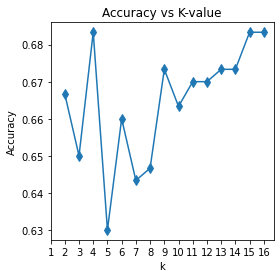

In [6]:
find_k(X_train_final, X_test_final, y_train, y_test, max_k=16)

k = 3 has the highest Accuracy score.

### KNeighborsClassifier:

In [7]:
knn = KNeighborsClassifier(3, weights='distance')

In [8]:
knn.fit(X_train_final, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

### Predictions:

In [9]:
y_train_pred = knn.predict(X_train_final)
y_test_pred = knn.predict(X_test_final)

### Validating the model:

In [10]:
def model_performance_classification(y_train, y_train_pred, y_test, y_test_pred):

    accuracy_train = accuracy_score(y_train,y_train_pred)
    accuracy_test  = accuracy_score(y_test,y_test_pred)

    precision_train = precision_score(y_train,y_train_pred, pos_label='summer school')
    precision_test  = precision_score(y_test,y_test_pred, pos_label='summer school')

    recall_train = recall_score(y_train,y_train_pred, pos_label='summer school')
    recall_test  = recall_score(y_train,y_train_pred, pos_label='summer school')

    f1_train = f1_score(y_train,y_train_pred, pos_label='summer school')
    f1_test  = f1_score(y_train,y_train_pred, pos_label='summer school')
    
    kappa_train = cohen_kappa_score(y_train, y_train_pred)
    kappa_test = cohen_kappa_score(y_test, y_test_pred)

    performance = pd.DataFrame({'Error_metric': ['Accuracy score','Precision score','Recall score',
                                                 'F1 score', 'Kappa score'],
                            'Train': [accuracy_train, precision_train, recall_train, f1_train, kappa_train],
                            'Test' : [accuracy_test, precision_test, recall_test, f1_test, kappa_test]})

    pd.options.display.float_format = '{:.2f}'.format

    df_train = pd.DataFrame({'Real': y_train.tolist(), 'Predicted': y_train_pred.tolist()})
    df_test  = pd.DataFrame({'Real': y_test.tolist(),  'Predicted': y_test_pred.tolist()})

    return performance, df_train, df_test

In [11]:
model_performance_classification(y_train, y_train_pred, y_test, y_test_pred)

(      Error_metric  Train  Test
 0   Accuracy score   0.75  0.65
 1  Precision score   0.69  0.52
 2     Recall score   0.75  0.75
 3         F1 score   0.72  0.72
 4      Kappa score   0.49  0.28,
               Real      Predicted
 0    good standing  good standing
 1    summer school  summer school
 2    good standing  good standing
 3    summer school  summer school
 4    summer school  summer school
 ..             ...            ...
 695  good standing  good standing
 696  good standing  summer school
 697  good standing  summer school
 698  good standing  summer school
 699  good standing  good standing
 
 [700 rows x 2 columns],
               Real      Predicted
 0    good standing  summer school
 1    good standing  good standing
 2    summer school  good standing
 3    good standing  summer school
 4    good standing  good standing
 ..             ...            ...
 295  good standing  summer school
 296  good standing  good standing
 297  summer school  summer school
 298

### Saving the model:

In [15]:
pickle.dump(knn, open('knn_classifier.pkl', 'wb'))